# Final country exploration (any country)

## Imports

In [1]:
# imports
import boundarytools
import numpy as np

import json
from urllib.request import urlopen

## Load in a set of country boundaries from NaturalEarth and GADM

In [2]:
# set params
country = 'CYP' #'TUN' #'BDI' #'BLR' #'LUX' #'CHE'
level = 0
ignore_sources = [] #['geoBoundaries (Open)', 'geoBoundaries (Authoritative)']

## Loop all pairs of sources and calculate

available sources: dict_keys(['GADM v3.6', 'Natural Earth v4.1', 'geoBoundaries (Open)'])

GADM v3.6 vs Natural Earth v4.1
--> 85.59% probability of being the same in source2


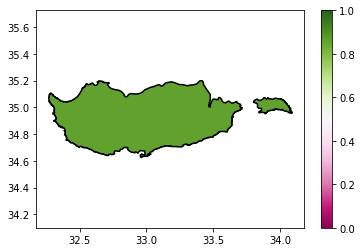


Total country probability that a random point in source1 is the same boundary as in source2:
--> 85.59%

GADM v3.6 vs geoBoundaries (Open)
--> 62.14% probability of being the same in source2


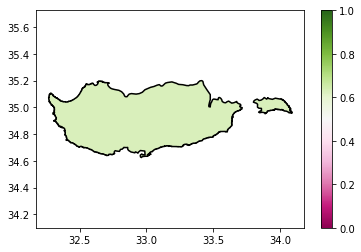


Total country probability that a random point in source1 is the same boundary as in source2:
--> 62.14%

Row total probability
--> 73.87% probability of being for a randomly selected source [0.8559340169679429, 0.6214282740606523]


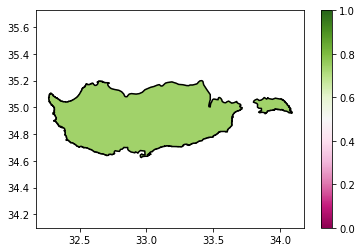


Total country probability that a random point in source1 is the same boundary as in a randomly selected source:
--> 73.87%

Natural Earth v4.1 vs GADM v3.6
--> 90.93% probability of being the same in source2


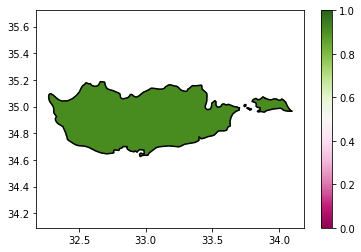


Total country probability that a random point in source1 is the same boundary as in source2:
--> 90.93%

Natural Earth v4.1 vs geoBoundaries (Open)
--> 57.22% probability of being the same in source2


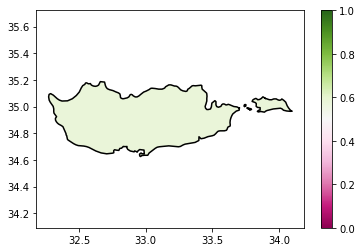


Total country probability that a random point in source1 is the same boundary as in source2:
--> 57.22%

Row total probability
--> 74.07% probability of being for a randomly selected source [0.909267351520247, 0.5722165576408894]


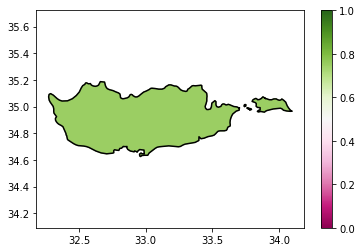


Total country probability that a random point in source1 is the same boundary as in a randomly selected source:
--> 74.07%

geoBoundaries (Open) vs GADM v3.6
--> 39.42% probability of being the same in source2


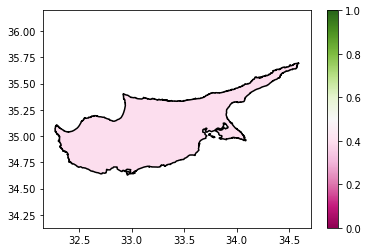


Total country probability that a random point in source1 is the same boundary as in source2:
--> 39.42%

geoBoundaries (Open) vs Natural Earth v4.1
--> 34.17% probability of being the same in source2


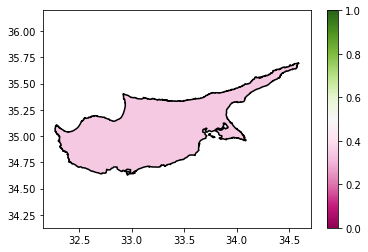


Total country probability that a random point in source1 is the same boundary as in source2:
--> 34.17%

Row total probability
--> 36.79% probability of being for a randomly selected source [0.3941555164204816, 0.34165337059603]


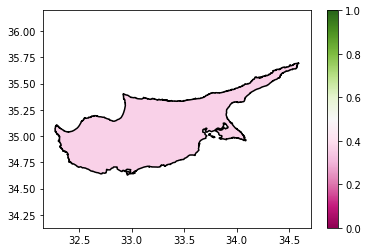


Total country probability that a random point in source1 is the same boundary as in a randomly selected source:
--> 36.79%

Column total probability


In [3]:
import io
import cProfile, pstats

profiler = cProfile.Profile()
profiler.enable()

# first get all possible sources
sourcedict = boundarytools.utils.find_geocontrast_sources(country, level)
print('available sources:', sourcedict.keys())

# next loop all pairs of sources
source_maps_matrix = {}
source_results_matrix = {}
for source1,url1 in sourcedict.items():
    if source1 in ignore_sources: continue
    if 'geoBoundaries' in source1:
        url1 = url1.replace('.topojson','.geojson')
        coll1 = boundarytools.utils.load_geojson_url(url1, load_shapely=True)
    else:
        coll1 = boundarytools.utils.load_topojson_url(url1, load_shapely=True)

    # simplify
    for feat in coll1['features']:
        feat['shapely'] = feat['shapely'].buffer(0).simplify(0.01)
        
    mainfeats = coll1['features']
    
    source_maps_row = {}
    source_results_row = {}
    
    for feat1 in mainfeats:
        feat1['properties']['probability_same_list'] = []
        
    from shapely.ops import cascaded_union
    union = cascaded_union([feat['shapely'] for feat in mainfeats])
    aggfeat = {'type':'Feature', 'geometry':None, 'shapely':union, 'properties':{}}
    
    for source2,url2 in sourcedict.items():
        if source2 == source1: continue
        if source2 in ignore_sources: continue
        print('')
        print(source1, 'vs', source2)
        if 'geoBoundaries' in source2:
            url2 = url2.replace('.topojson','.geojson')
            coll2 = boundarytools.utils.load_geojson_url(url2, load_shapely=True)
        else:
            coll2 = boundarytools.utils.load_topojson_url(url2, load_shapely=True)
            
        # simplify
        for feat in coll2['features']:
            feat['shapely'] = feat['shapely'].buffer(0).simplify(0.01)
        
        # show both dataset boundaries
        #boundarytools.utils.show_datasets(coll1, coll2)
        
        # loop features
        otherfeats = coll2['features']
        for feat1 in mainfeats:
            #print(feat1['properties'])
            probability_same = boundarytools.compare.probability_feature_same_as_features(feat1, otherfeats)
            feat1['properties']['probability_same'] = probability_same
            feat1['properties']['probability_same_list'].append(probability_same)
            print('--> {:.2f}% probability of being the same in source2'.format(probability_same*100))

        # show probabilities on map
        boundarytools.utils.show_dataset({'type':'FeatureCollection', 'features':mainfeats},
                                        color_by='probability_same',
                                        minval=0.0, maxval=1.0)
        fobj = io.BytesIO()
        import matplotlib.pyplot as plt
        plt.savefig(fobj, format='png', bbox_inches="tight")
        plt.show()

        # calc total probability for country
        probagg = boundarytools.compare.probabilities_aggregate(mainfeats, aggfeat, 'probability_same')
        print('')
        print('Total country probability that a random point in source1 is the same boundary as in source2:')
        print('--> {:.2f}%'.format(probagg*100))
        
        # add to results matrix row
        source_maps_row[source2] = fobj.getvalue()
        source_results_row[source2] = probagg
        
        
    #######################################
    # and again for row total probabilities
    print('')
    print('Row total probability')
        
    # calc row total probabilities
    for feat1 in mainfeats:
        probabilities = feat1['properties']['probability_same_list']
        probability_same_all = 0
        for probability_same in probabilities:
            probability_source_selected = 1 / len(probabilities)
            probability_same_all += probability_source_selected * probability_same
        feat1['properties']['probability_same_all'] = probability_same_all
        print('--> {:.2f}% probability of being for a randomly selected source'.format(probability_same_all*100), probabilities)
        
    # show probabilities on map
    boundarytools.utils.show_dataset({'type':'FeatureCollection', 'features':mainfeats},
                                    color_by='probability_same_all',
                                    minval=0.0, maxval=1.0)
    fobj = io.BytesIO()
    import matplotlib.pyplot as plt
    plt.savefig(fobj, format='png', bbox_inches="tight")
    plt.show()

    # calc total probability for country
    probagg = boundarytools.compare.probabilities_aggregate(mainfeats, aggfeat, 'probability_same_all')
    print('')
    print('Total country probability that a random point in source1 is the same boundary as in a randomly selected source:')
    print('--> {:.2f}%'.format(probagg*100))

    # add to results matrix row
    source_maps_row['Row Total'] = fobj.getvalue()
    source_results_row['Row Total'] = probagg
    
    ########################
    
    # add to results matrix
    source_maps_matrix[source1] = source_maps_row
    source_results_matrix[source1] = source_results_row

#######################################
# and again for column total probabilities
print('')
print('Column total probability')

sources = sourcedict.keys()

source_results_matrix['Col Total'] = {}
for source in sources:
    probs = []
    for source2 in sources:
        if source==source2: 
            continue
        prob = source_results_matrix[source2][source]
        probs.append(prob)
    tot = np.mean(probs)
    source_results_matrix['Col Total'][source] = tot
    
probs = []
for source in sources:
    prob = source_results_matrix[source]['Row Total']
    probs.append(prob)
tot = np.mean(probs)
source_results_matrix['Col Total']['Row Total'] = tot
    
profiler.disable()

source similarity/probability matrix for CYP-ADM0


,GADM v3.6,Natural Earth v4.1,geoBoundaries (Open),Row Total
GADM v3.6,100.0000%,85.5934%,62.1428%,73.8681%
Natural Earth v4.1,90.9267%,100.0000%,57.2217%,74.0742%
geoBoundaries (Open),39.4156%,34.1653%,100.0000%,36.7904%
Col Total,65.1711%,59.8794%,59.6822%,61.5776%

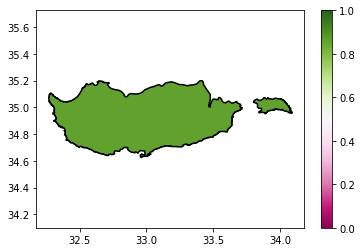
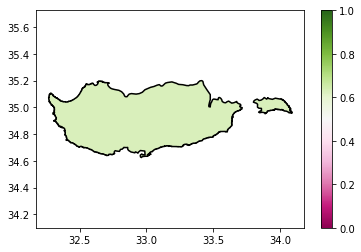
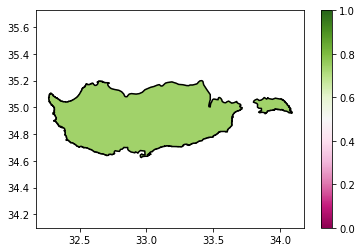
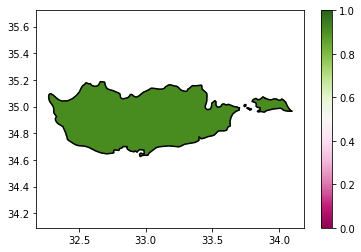
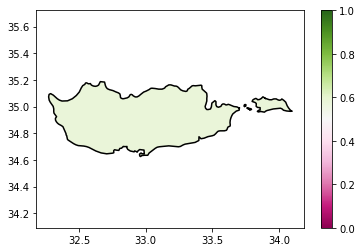
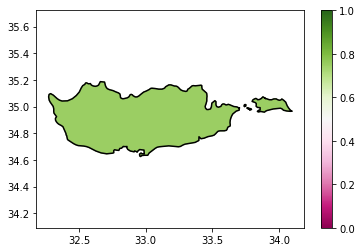
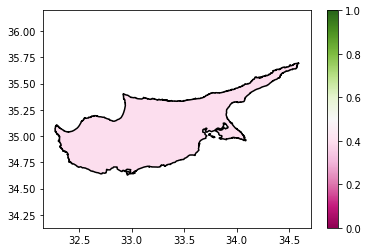
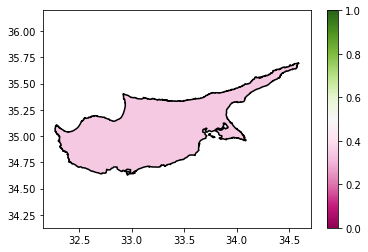
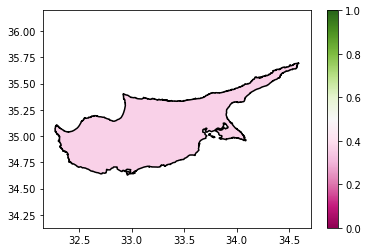

rowtottot 0.6157758478677072
coltottot 0.6157758478677072


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/CYP-ADM0.html'

In [4]:
# convert results matrix dicts to list of lists
import base64
sources = sourcedict.keys()
table = []
vtable = [] # values only
table.append([''] + list(sources) + ['Row Total'])
vtable.append([''] + list(sources) + ['Row Total'])
for source1 in list(sources) + ['Col Total']:
    row = [source1]
    vrow = [source1]
    for source2 in list(sources) + ['Row Total']:
        if source1 == source2:
            probagg = 1
            imgtag = ''
        else:
            probagg = source_results_matrix[source1][source2]
            if source1 == 'Col Total':
                imgtag = ''
            else:
                imgbytes = source_maps_matrix[source1][source2]
                imgascii = base64.b64encode(imgbytes).decode('ascii')
                imgtag = '<img src="data:image/png;base64,{0}" width="80px">'.format(imgascii)
        probtag = '<span>{:.4f}%</span>'.format(probagg*100)
        cell = imgtag + probtag
        row.append(cell)
        vrow.append(probagg)
    table.append(row)
    vtable.append(vrow)

# show results matrix
print('source similarity/probability matrix for {}-ADM{}'.format(country,level))
from IPython.display import HTML, display
htmlstring = '<table>'
for row in table:
    htmlstring += '<tr>'
    for cell in row:
        htmlstring += '<td style="text-align:center">'
        htmlstring += cell
        htmlstring += '</td>'
    htmlstring += '</tr>'
htmlstring += '</table>'
display(HTML(htmlstring))

rowtottot = [vtable[-1][i] for i in range(1, len(vtable)-1)]
print('rowtottot', np.mean(rowtottot))
coltottot = [vtable[i][-1] for i in range(1, len(vtable)-1)]
print('coltottot', np.mean(coltottot))

with open('outputs/{}-ADM{}.html'.format(country,level), 'w') as fobj:
    fobj.write(htmlstring)

In [ ]:
stats = pstats.Stats(profiler)
stats.sort_stats('cumtime').print_stats()#'boundarytools')

In [ ]:
stats.sort_stats('tottime').print_stats()#'boundarytools')